In [1]:
import pandas as pd
import numpy as np

In [2]:
df_votants = pd.read_csv('database_deputes.csv', index_col=0)
df_votes = pd.read_csv('database_votes2.csv', index_col=0)

In [3]:
df_votes['Pour'] = np.where(df_votes['vote']== 'Pour', 1, 0)
df_votes['Contre'] = np.where(df_votes['vote']== 'Contre', 1, 0)
df_votes['Non-votant'] = np.where(df_votes['vote']== 'Non-votant', 1, 0)

In [4]:
df_votes[df_votes['date_scrutin'].str.startswith('2020')].groupby('idScrutin').count() #701 scrutins
df_votes[df_votes['date_scrutin'].str.startswith('2019')].groupby('idScrutin').count() #804 scrutins
df_votes[df_votes['date_scrutin'].str.startswith('2018')].groupby('idScrutin').count() #1255 scrutins
df_votes[df_votes['date_scrutin'].str.startswith('2017')].groupby('idScrutin').count() #357 scrutins

,idVotant,vote,organeRefGroupe,date_scrutin,code_type_vote,titre,demandeur,organe_ref,votants,pour,...,Profession,Groupe politique (complet),Groupe politique (abrégé),date_naissance,type_mandat,type_organe,qualite_mandat,Pour,Contre,Non-votant
idScrutin,,,,,,,,,,,,,,,,,,,,,
3,97,97,97,97,97,97,97,97,97,97,...,97,97,97,8,8,8,8,97,97,97
13,74,74,74,74,74,74,74,74,74,74,...,74,74,74,8,8,8,8,74,74,74
14,85,85,85,85,85,85,85,85,85,85,...,84,85,85,4,4,4,4,85,85,85
22,126,126,126,126,126,126,126,126,126,126,...,125,126,126,7,7,7,7,126,126,126
33,156,156,156,156,156,156,156,156,156,156,...,155,156,156,13,13,13,13,156,156,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3099,50,50,50,50,50,50,50,50,50,50,...,48,50,50,7,7,7,7,50,50,50
3102,396,396,396,396,396,396,396,396,396,396,...,392,396,396,75,75,75,75,396,396,396
3110,77,77,77,77,77,77,77,77,77,77,...,77,77,77,8,8,8,8,77,77,77


In [5]:
df_2020 = df_votes[df_votes['date_scrutin'].str.startswith('2020')]
df_2019 = df_votes[df_votes['date_scrutin'].str.startswith('2019')]
df_2018 = df_votes[df_votes['date_scrutin'].str.startswith('2018')]
df_2017 = df_votes[df_votes['date_scrutin'].str.startswith('2017')]

In [6]:
def accord_parti_annee (df_votes):
    df_grouped = df_votes[['vote', 'Pour', 'Contre', 'Non-votant', 'idScrutin', 'Groupe politique (complet)']].groupby(['Groupe politique (complet)', 'idScrutin']).sum()
    df_grouped = df_grouped.assign(vote_maj_parti=df_grouped.idxmax(1))
    df_grouped = df_grouped.drop(['Pour', 'Contre', 'Non-votant'], axis =1)
    df_votes2 = df_votes.merge(df_grouped, on=['Groupe politique (complet)', 'idScrutin'], how='left')
    Partis = pd.DataFrame(df_votes2.groupby('idVotant')['Groupe politique (complet)'].unique())
    df3= df_votes2[((df_votes2.vote == 'Pour') & (df_votes2.vote_maj_parti == 'Pour')) | ((df_votes2.vote == 'Contre') & (df_votes2.vote_maj_parti == 'Contre')) | ((df_votes2.vote == 'Non-votant') & (df_votes2.vote_maj_parti == 'Non-votant'))]

    Accord_votant = df3.idVotant.value_counts() 
    Total_votant = df_votes2.idVotant.value_counts()

    IndiceAccordParti=[]
    
    Votants2=df3['idVotant'].unique()

    for votant in Votants2:     
        IndiceAccordParti.append(int(Accord_votant[votant])/int(Total_votant[votant])*100)
    
    IndiceAccordPartiDF = pd.DataFrame({'idVotant' : Votants2,
                               'IndiceAccordParti' : IndiceAccordParti})
    return (IndiceAccordPartiDF)

In [7]:
accord_2020 = accord_parti_annee(df_2020)
accord_2020=accord_2020.rename(columns = {'IndiceAccordParti' : 'indice_accord_2020'})
df_votes = df_votes.merge(accord_2020, on = 'idVotant')

In [8]:
accord_2019 = accord_parti_annee(df_2019)
accord_2019=accord_2019.rename(columns = {'IndiceAccordParti' : 'indice_accord_2019'})
df_votes = df_votes.merge(accord_2019, on = 'idVotant')

In [9]:
accord_2018 = accord_parti_annee(df_2018)
accord_2018=accord_2018.rename(columns = {'IndiceAccordParti' : 'indice_accord_2018'})
df_votes = df_votes.merge(accord_2018, on = 'idVotant')

In [10]:
accord_2017 = accord_parti_annee(df_2017)
accord_2017=accord_2017.rename(columns = {'IndiceAccordParti' : 'indice_accord_2017'})
df_votes = df_votes.merge(accord_2017, on = 'idVotant')

In [11]:
df_accord = df_votes[['idVotant', 'Groupe politique (complet)', 'indice_accord_2020', 'indice_accord_2019', 'indice_accord_2018', 'indice_accord_2017']].drop_duplicates()

In [12]:
df_accord = df_accord.set_index('idVotant')

In [13]:
df_accord #573 députés ?????? 

,Groupe politique (complet),indice_accord_2020,indice_accord_2019,indice_accord_2018,indice_accord_2017
idVotant,,,,,
PA606171,La République en Marche,23.652174,24.256651,28.917197,39.759036
PA721824,La République en Marche,43.506494,25.870647,38.327526,54.629630
PA719952,La République en Marche,100.000000,99.363057,99.319728,99.074074
PA607395,La République en Marche,100.000000,97.777778,100.000000,94.117647
PA718710,La République en Marche,96.929825,96.956522,98.055556,97.163121
...,...,...,...,...,...
PA643004,UDI et Indépendants,100.000000,100.000000,100.000000,100.000000
PA774958,Socialistes et apparentés,100.000000,100.000000,100.000000,100.000000
PA643192,Socialistes et apparentés,92.307692,100.000000,90.000000,66.666667


In [14]:
df_accord = df_accord.rename(columns = {'indice_accord_2017' : pd.to_datetime('2017'), 
                            'indice_accord_2018' : pd.to_datetime('2018'),
                            'indice_accord_2019' : pd.to_datetime('2019'),
                            'indice_accord_2020' : pd.to_datetime('2020')})

In [15]:
df_accord = df_accord.drop('Groupe politique (complet)', axis =1)

In [16]:
df_accord_T = df_accord.transpose()

In [17]:
df_accord_T

idVotant,PA606171,PA721824,PA719952,PA607395,PA718710,PA718802,PA719032,PA719100,PA719108,PA719154,...,PA604,PA774952,PA774956,PA719002,PA720006,PA643004,PA774958,PA643192,PA721768,PA720802
2020-01-01 00:00:00,23.652174,43.506494,100.000000,100.000000,96.929825,100.000000,99.561404,100.000000,97.395833,97.247706,...,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,92.307692,100.0,80.000000
2019-01-01 00:00:00,24.256651,25.870647,99.363057,97.777778,96.956522,97.540984,99.500000,97.959184,91.666667,96.475771,...,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,100.000000,100.0,100.000000
2018-01-01 00:00:00,28.917197,38.327526,99.319728,100.000000,98.055556,97.727273,100.000000,97.887324,96.405229,96.774194,...,100.0,83.333333,100.0,100.0,100.0,100.0,100.0,90.000000,100.0,55.555556
2017-01-01 00:00:00,39.759036,54.629630,99.074074,94.117647,97.163121,100.000000,100.000000,98.387097,98.148148,97.087379,...,100.0,100.000000,100.0,100.0,100.0,100.0,100.0,66.666667,100.0,100.000000


In [18]:
#df_accord = df_accord.drop('cluster', axis =1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_accord_T)
df = pd.DataFrame(scaler.transform(df_accord_T), columns = df_accord_T.columns, index = df_accord_T.index)

In [19]:
df_stand = df.T

In [20]:
df_stand 

,2020-01-01 00:00:00,2019-01-01 00:00:00,2018-01-01 00:00:00,2017-01-01 00:00:00
idVotant,,,,
PA606171,-0.850860,-0.757246,-0.035475,1.643581
PA721824,0.282769,-1.423359,-0.218255,1.358844
PA719952,1.639672,-0.222676,-0.349366,-1.067630
PA607395,0.842777,-0.081559,0.842777,-1.603995
PA718710,-0.754918,-0.696742,1.698196,-0.246536
...,...,...,...,...
PA643004,0.000000,0.000000,0.000000,0.000000
PA774958,0.000000,0.000000,0.000000,0.000000
PA643192,0.406962,1.025133,0.221511,-1.653607


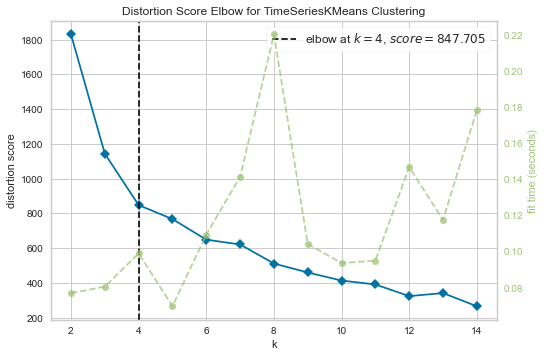

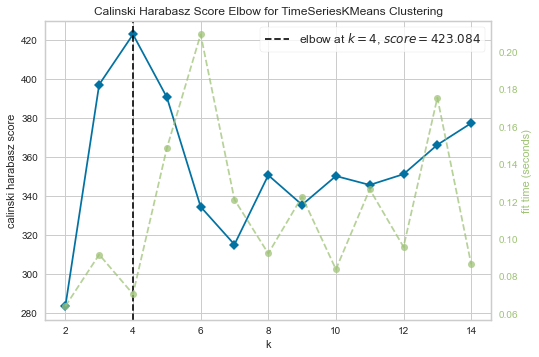

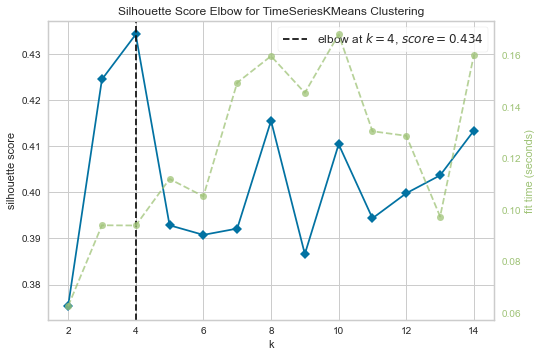

In [46]:
from tslearn.clustering import TimeSeriesKMeans
from yellowbrick.cluster import KElbowVisualizer

liste_metrics = ['distortion', 'calinski_harabasz', 'silhouette']
#on teste la règle du coude avec trois métriques différentes : 
# distorsion = somme au carré des distances de chaque point à son centroïde
# calinski_harabasz = ratio entre la dispersion entre clusters et la dispersion dans le cluster
# silhouette = moyenne du ratio entre la distance au centroïde de son cluster et la distance au centroïde le plus proche

i=1
for metric in liste_metrics:
    model = TimeSeriesKMeans()
    visualizer = KElbowVisualizer(model, k=(2,15), metric=metric) 
    visualizer.fit(df_stand)       
    visualizer.show() 
i=+1

Les graphe ne sont pas incroyables. Est-ce que c'est vraiment pertinent de faire des clusters ???? 

In [40]:
#df_accord = df_accord.drop('cluster', axis =1)
import statistics
import tslearn
from tslearn.clustering import TimeSeriesKMeans


model = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10)
Fit = model.fit(df_stand)

In [41]:
pred = Fit.labels_
df_stand['cluster'] = pred

In [42]:
df_cluster = df_stand

In [43]:
df_cluster_0 = df_cluster[df_cluster['cluster'].isin(['0'])]
df_cluster_1 = df_cluster[df_cluster['cluster'].isin(['1'])]
df_cluster_2 = df_cluster[df_cluster['cluster'].isin(['2'])]
df_cluster_3 = df_cluster[df_cluster['cluster'].isin(['3'])]

In [44]:
df_cluster_0
#df_cluster_1
#df_cluster_2
#df_cluster_3

,2020-01-01 00:00:00,2019-01-01 00:00:00,2018-01-01 00:00:00,2017-01-01 00:00:00,cluster
idVotant,,,,,
PA721824,0.282769,-1.423359,-0.218255,1.358844,0
PA718802,0.998454,-1.077072,-0.919835,0.998454,0
PA719100,1.688143,-0.701696,-0.785846,-0.200601,0
PA719108,0.591237,-1.679276,0.198653,0.889386,0
PA719154,1.185135,-1.417976,-0.411639,0.644480,0
...,...,...,...,...,...
PA720006,0.000000,0.000000,0.000000,0.000000,0
PA643004,0.000000,0.000000,0.000000,0.000000,0
PA774958,0.000000,0.000000,0.000000,0.000000,0


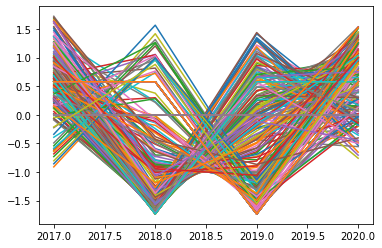

In [26]:
df_cluster_0 = df_cluster_0.drop('cluster', axis=1)
votants = df_cluster_0.index
for votant in votants:
    evolution = []
    date =list(df_cluster_0.columns)
    for annee in date : 
        evolution.append(df_cluster_0.loc[votant][annee])
    import matplotlib.pyplot as plt
    x = [2017, 2018, 2019, 2020]
    plt.plot(x, evolution)

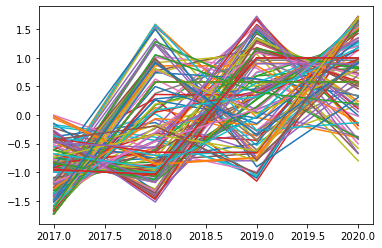

In [27]:
df_cluster_1 = df_cluster_1.drop('cluster', axis=1)
votants = df_cluster_1.index
for votant in votants:
    evolution = []
    date =list(df_cluster_1.columns)
    for annee in date : 
        evolution.append(df_cluster_1.loc[votant][annee])
    import matplotlib.pyplot as plt
    x = [2017, 2018, 2019, 2020]
    plt.plot(x, evolution)

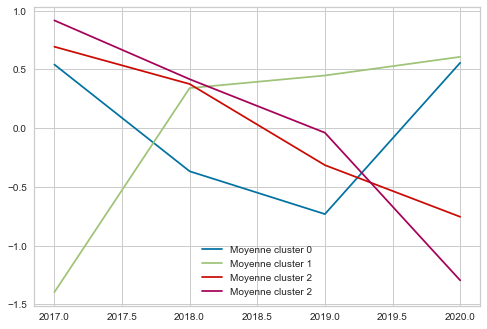

In [45]:
mean0 = []
for i in range(4):
    mean0.append(df_cluster_0[df_cluster_0.columns[3-i]].mean())
mean1 = []
for i in range(4):
    mean1.append(df_cluster_1[df_cluster_1.columns[3-i]].mean())
    
mean2 = []
for i in range(4):
    mean2.append(df_cluster_2[df_cluster_2.columns[3-i]].mean())
    
mean3 = []
for i in range(4):
    mean3.append(df_cluster_3[df_cluster_3.columns[3-i]].mean())

x = [2017, 2018, 2019, 2020]
plt.plot(x, mean0)
plt.plot(x, mean1)
plt.plot(x, mean2)
plt.plot(x, mean3)
label = ['Moyenne cluster 0', 'Moyenne cluster 1','Moyenne cluster 2','Moyenne cluster 2']
plt.legend(labels = label)

In [47]:
group = df_votes[['idVotant', 'Groupe politique (complet)']]
group = group.set_index('idVotant')

In [48]:
b = df_cluster.merge(group, on = "idVotant")

In [49]:
b = b.drop_duplicates()

In [50]:
b #544 députés ????? 

,2020-01-01 00:00:00,2019-01-01 00:00:00,2018-01-01 00:00:00,2017-01-01 00:00:00,cluster,Groupe politique (complet)
idVotant,,,,,,
PA606171,-0.850860,-0.757246,-0.035475,1.643581,3,La République en Marche
PA721824,0.282769,-1.423359,-0.218255,1.358844,0,La République en Marche
PA719952,1.639672,-0.222676,-0.349366,-1.067630,1,La République en Marche
PA607395,0.842777,-0.081559,0.842777,-1.603995,1,La République en Marche
PA718710,-0.754918,-0.696742,1.698196,-0.246536,2,La République en Marche
...,...,...,...,...,...,...
PA774952,0.577350,0.577350,-1.732051,0.577350,0,Les Républicains
PA720006,0.000000,0.000000,0.000000,0.000000,0,Mouvement Démocrate (MoDem) et Démocrates appa...
PA643004,0.000000,0.000000,0.000000,0.000000,0,UDI et Indépendants


In [52]:
b[b['cluster'].isin(['0'])]['Groupe politique (complet)'].unique()

array(['La République en Marche', 'Les Républicains',
       'Mouvement Démocrate (MoDem) et Démocrates apparentés',
       'Socialistes et apparentés', 'UDI et Indépendants',
       'Libertés et Territoires', 'La France insoumise', 'Non inscrit',
       'Agir ensemble', 'Gauche démocrate et républicaine'], dtype=object)

In [53]:
b[b['cluster'].isin(['1'])]['Groupe politique (complet)'].unique()

array(['La République en Marche', 'Les Républicains', 'Agir ensemble',
       'Libertés et Territoires', 'Non inscrit',
       'Socialistes et apparentés', 'Gauche démocrate et républicaine',
       'Mouvement Démocrate (MoDem) et Démocrates apparentés',
       'UDI et Indépendants'], dtype=object)

In [54]:
b[b['cluster'].isin(['2'])]['Groupe politique (complet)'].unique()

array(['La République en Marche', 'Les Républicains', 'Non inscrit',
       'Mouvement Démocrate (MoDem) et Démocrates apparentés',
       'Libertés et Territoires', 'Gauche démocrate et républicaine',
       'UDI et Indépendants', 'Socialistes et apparentés'], dtype=object)

In [55]:
b[b['cluster'].isin(['3'])]['Groupe politique (complet)'].unique()

array(['La République en Marche', 'Les Républicains',
       'Socialistes et apparentés', 'Libertés et Territoires',
       'Mouvement Démocrate (MoDem) et Démocrates apparentés',
       'Gauche démocrate et républicaine', 'La France insoumise',
       'UDI et Indépendants', 'Non inscrit', 'Agir ensemble'],
      dtype=object)

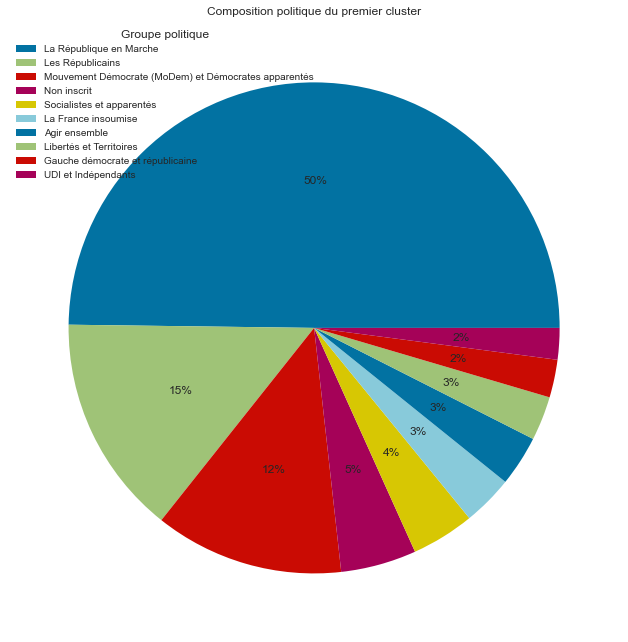

In [56]:
plt.figure(1, figsize=(11, 13))

g = plt.pie(b[b['cluster'].isin(['0'])]['Groupe politique (complet)'].value_counts(normalize=True), autopct='%1.0f%%',
            labeldistance=None)
plt.title("Composition politique du premier cluster")
labels = b[b['cluster'].isin(['0'])]['Groupe politique (complet)'].value_counts().index
plt.legend(labels=labels, title='Groupe politique', loc='upper left')
#g.set_xticklabels(g.get_xticklabels(), rotation=40, ha='right')
plt.show()

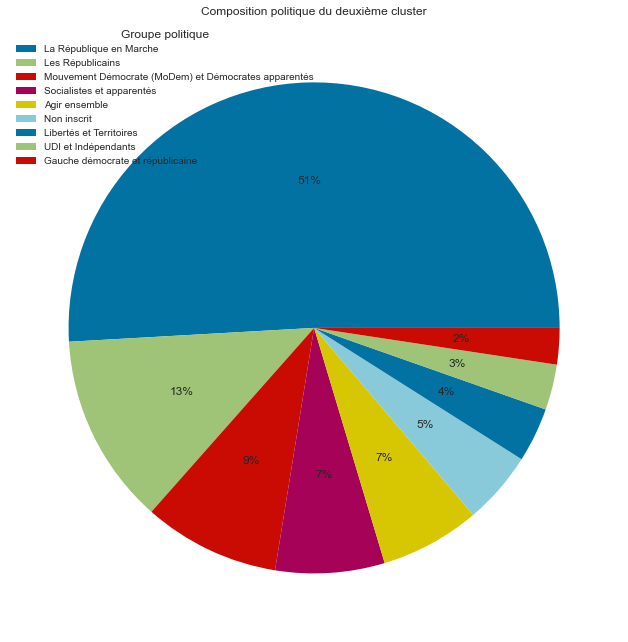

In [57]:
plt.figure(1, figsize=(11, 13))

g = plt.pie(b[b['cluster'].isin(['1'])]['Groupe politique (complet)'].value_counts(normalize=True), autopct='%1.0f%%',
            labeldistance=None)
plt.title("Composition politique du deuxième cluster")
labels = b[b['cluster'].isin(['1'])]['Groupe politique (complet)'].value_counts().index
plt.legend(labels=labels, title='Groupe politique', loc='upper left')
#g.set_xticklabels(g.get_xticklabels(), rotation=40, ha='right')
plt.show()

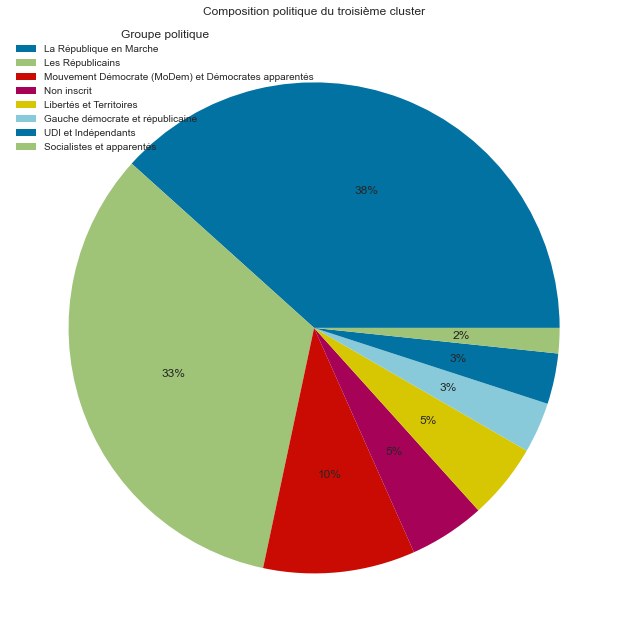

In [58]:
plt.figure(1, figsize=(11, 13))

g = plt.pie(b[b['cluster'].isin(['2'])]['Groupe politique (complet)'].value_counts(normalize=True), autopct='%1.0f%%',
            labeldistance=None)
plt.title("Composition politique du troisième cluster")
labels = b[b['cluster'].isin(['2'])]['Groupe politique (complet)'].value_counts().index
plt.legend(labels=labels, title='Groupe politique', loc='upper left')
#g.set_xticklabels(g.get_xticklabels(), rotation=40, ha='right')
plt.show()

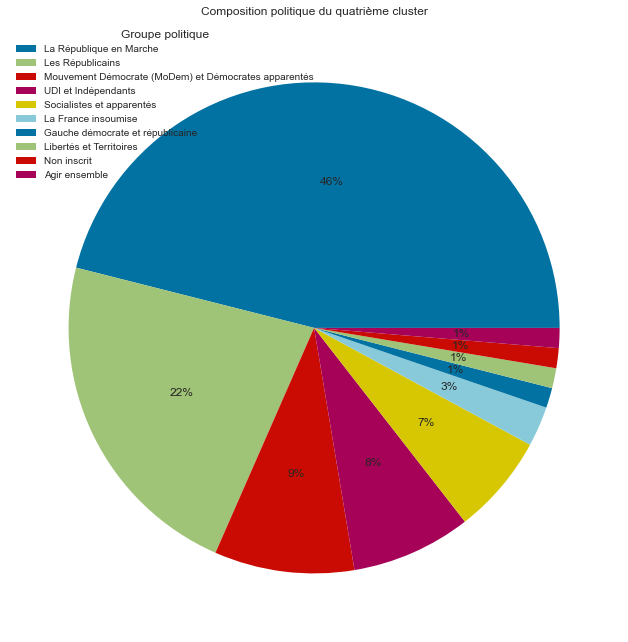

In [59]:
plt.figure(1, figsize=(11, 13))

g = plt.pie(b[b['cluster'].isin(['3'])]['Groupe politique (complet)'].value_counts(normalize=True), autopct='%1.0f%%',
            labeldistance=None)
plt.title("Composition politique du quatrième cluster")
labels = b[b['cluster'].isin(['3'])]['Groupe politique (complet)'].value_counts().index
plt.legend(labels=labels, title='Groupe politique', loc='upper left')
#g.set_xticklabels(g.get_xticklabels(), rotation=40, ha='right')
plt.show()